# `tanh` vs `ReLU` in a small CNN

Section 3.1 in the [AlexNet](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
paper claims that `tanh` takes much longer to reach 25% accuracy on the training
data than `ReLU`. [PDLT](https://arxiv.org/abs/2106.10165) shows that `tanh` can
reach criticality if it's initialized correctly. 

I'm not sure what the CNN inititalization should be, need to work out this
math myself. I just initialized the linear layers according to PDLT. Seems to work
pretty fine!

Here's Figure 1 in the AlexNet paper: 

![](../assets/alexnet-fig1.png)

In [1]:
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from IPython.display import clear_output

In [2]:
# ToTensor scales [0,255] to [0.0, 1.0]
transform = torchvision.transforms.ToTensor()
train_set = torchvision.datasets.CIFAR10(
    root="../datasets",
    transform=transform,
    download=True,
    train=True
)
val_set = torchvision.datasets.CIFAR10(
    root="../datasets",
    transform=transform,
    download=True,
    train=False
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_set, val_set

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ../datasets
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ../datasets
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [4]:
train_set.class_to_idx, val_set.class_to_idx

({'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9},
 {'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9})

torch.Size([3, 32, 32])
6


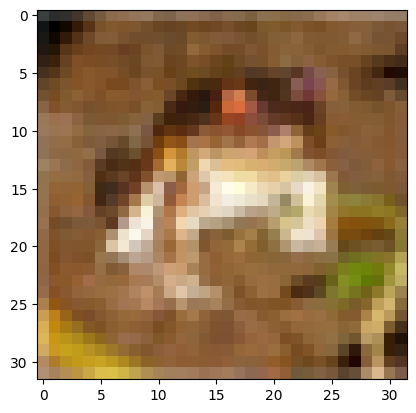

In [5]:
image, label = train_set[0]
print(image.shape)
print(label)
# imshow wants (height, width, channels)
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()

In [6]:
class ReasonablyDeepCNN(nn.Module):
    """4 CNNs with max pooling and 2 FCNs."""

    def __init__(self, activation_name: Literal["relu", "tanh"], n_classes=100):
        super().__init__()

        activation = nn.ReLU if activation_name == "relu" else nn.Tanh

        # CIFAR-10 is (3, 32, 32)
        self.layers = nn.Sequential(
            # (b, 3, 32, 32) -> (b, 64, 32, 32)
            nn.Conv2d(3, 64, (3, 3), stride=1, padding="same"),
            activation(),
            # (b, 64, 32, 32) -> (b, 64, 16, 16)
            nn.MaxPool2d((2, 2), stride=2),
            # (b, 64, 16, 16) -> (b, 128, 16, 16)
            nn.Conv2d(64, 128, (3, 3), stride=1, padding="same"),
            activation(),
            # (b, 128, 16, 16) -> (b, 128, 8, 8)
            nn.MaxPool2d((2, 2), stride=2),
            # (b, 128, 8, 8) -> (b, 256, 8, 8)
            nn.Conv2d(128, 256, (3, 3), stride=1, padding="same"),
            activation(),
            # (b, 256, 8, 8)  -> (b, 256, 4, 4)
            nn.MaxPool2d((2, 2), stride=2),
            # (b, 256, 4, 4) -> (b, 512, 4, 4)
            nn.Conv2d(256, 512, (3, 3), stride=1, padding="same"),
            activation(),
            # (b, 512, 4, 4) -> (b, 512, 2, 2)
            nn.MaxPool2d((2, 2), stride=2),
            # (b, 512, 2, 2) -> (b, 2048)
            nn.Flatten(),
            # (b, 2048) -> (b, 4096)
            nn.Dropout(0.5),
            nn.Linear(2048, 4096),
            activation(),
            # (b, 4096) -> (b, 128)
            nn.Dropout(0.5),
            nn.Linear(4096, 128), 
            activation(),
            nn.Linear(128, n_classes),
            nn.Softmax(dim=1),
        )

        # Initialization based on PDLT conditions for criticality
        for layer in self.layers:
            if isinstance(layer, nn.Conv2d):
                if activation_name == "relu":
                    nn.init.normal_(
                        layer.weight,
                        mean=0,
                        # std=(2 / (layer.kernel_size[0] * layer.kernel_size[1])) ** (1 / 2),
                        std = 0.01
                    )
                    nn.init.constant_(layer.bias, 0)
                else:
                    nn.init.normal_(
                        layer.weight,
                        mean=0,
                        # std=(1 / (layer.kernel_size[0] * layer.kernel_size[1])) ** (1 / 2),
                        std = 0.01
                    )
                    nn.init.constant_(layer.bias, 0)
            elif isinstance(layer, nn.Linear):
                if activation_name == "relu":
                    nn.init.normal_(layer.weight, mean=0, std=(2 / layer.out_features) ** (1 / 2))
                    nn.init.constant_(layer.bias, 0)
                else:
                    nn.init.normal_(layer.weight, mean=0, std=(1 / layer.out_features) ** (1 / 2))
                    nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        return self.layers(x)

In [7]:
# binary_train_set_indices = [i for i, (_, label) in enumerate(train_set) if label in [0, 1]]
# binary_train_set = torch.utils.data.Subset(train_set, binary_train_set_indices)
# binary_val_set_indices = [i for i, (_, label) in enumerate(val_set) if label in [0, 1]]
# binary_val_set = torch.utils.data.Subset(val_set, binary_val_set_indices)

In [8]:
# image, label = binary_val_set[6]
# print(image.shape)
# print(label)
# # imshow wants (height, width, channels)
# plt.imshow(np.transpose(image, (1, 2, 0)))
# plt.show()

In [9]:
# len(binary_train_set), len(binary_val_set)

In [10]:
def train(activation_name: Literal["relu", "tanh"]):
    LR = 0.0003
    BATCH_SIZE = 1024
    N_EPOCHS = 30

    net = ReasonablyDeepCNN(activation_name, n_classes=10).cuda()

    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(net.parameters(), lr=LR)

    losses = []
    accuracy = []
    vlosses = []

    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE * 2)
    for epoch in range(N_EPOCHS):
        total_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.cuda(), y.cuda()
            net.train()
            opt.zero_grad()

            pred = net(X)
            print(all([x[0] > 0.5 for x in pred]) or all([x[0] < 0.5 for x in pred]))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

            total_loss += loss.item()
        
        losses.append(total_loss / (batch + 1))

        # Need this because of dropout!
        net.eval()
        with torch.no_grad():
            total_vloss = 0

            correct = 0
            total = 0
            for vbatch, (X, y) in enumerate(val_dataloader):
                X, y = X.cuda(), y.cuda()
                pred = net(X)
                total_vloss += loss_fn(pred, y).item()
                _, predicted = torch.max(pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

            # print(f"{total_vloss=}")
            vlosses.append(total_vloss / (vbatch + 1))
            accuracy.append(correct / total)

        clear_output(wait=True)
        print(correct / total)
        plt.plot(losses, label="Training Loss")
        plt.plot(vlosses, label="Validation loss")
        plt.legend()
        plt.show()

    return losses, vlosses, accuracy


0.7


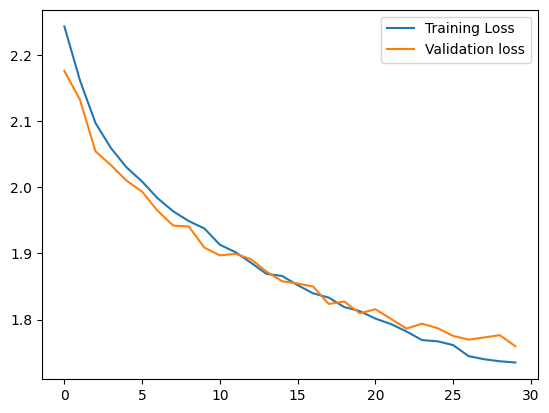

In [11]:
relu_losses, relu_vlosses, relu_accuracy = train("relu")

0.7052


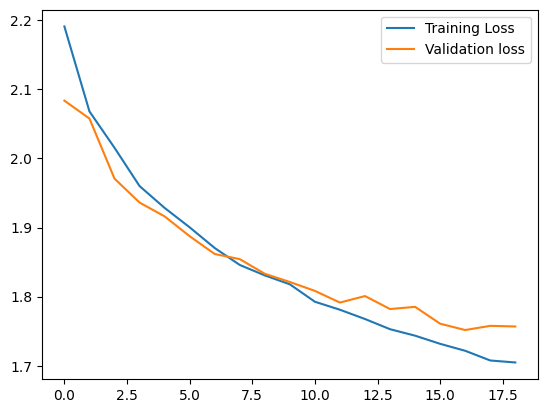

False
False


KeyboardInterrupt: 

In [12]:
tanh_losses, tanh_vlosses, tanh_accuracy = train("tanh")